# New York Airbnb

# Business Understanding
From the Airbnb listings dataset for New York we can get a better understanding of how the rental prices vary based on the neighbourhood and property type. We can also figure out some interesting correlations between the host and review ratings and features that possibly affect these ratings. The listings data can be cleansed, preprocessed and modeled to predict useful information. The following business questions were asked before diving into the dataset:


1. For different property types, what are average prices for different neighbourhoods?
2. What factors contribute towards a host rating? What aspects could possibly help a host get a better rating?
3. How can a host be entitled as a Superhost? How can they set a competitive rental price for their listing? How can a host maintain good review rating for their listing?

In [138]:
# Importing Packages
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import re
import math
import datetime

In [139]:
# Loading Data from CSV Files
SURVEY = os.path.join(os.getcwd(), 'listings.csv')

# Read CSV into Pandas dataframe
df = pd.read_csv(SURVEY)
df.head()


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (61,62,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2060,https://www.airbnb.com/rooms/2060,20200408162728,2020-04-09,Modern NYC,NaN,"Lovely, spacious, sunny 1 BR apartment in 6th ...","Lovely, spacious, sunny 1 BR apartment in 6th ...",none,NaN,...,f,f,flexible,f,f,1,0,1,0,0.01
1,2595,https://www.airbnb.com/rooms/2595,20200408162728,2020-04-10,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...","- Spacious (500+ft²), immaculate and nicely fu...","Beautiful, spacious skylit studio in the heart...",none,Centrally located in the heart of Manhattan ju...,...,f,f,strict_14_with_grace_period,t,t,2,2,0,0,0.38
2,3831,https://www.airbnb.com/rooms/3831,20200408162728,2020-04-11,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,...,f,f,moderate,f,f,1,1,0,0,4.68
3,5099,https://www.airbnb.com/rooms/5099,20200408162728,2020-04-10,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment has a true New Yo...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment has a true New Yo...,none,My neighborhood in Midtown East is called Murr...,...,f,f,moderate,t,t,1,1,0,0,0.58
4,5121,https://www.airbnb.com/rooms/5121,20200408162728,2020-04-09,BlissArtsSpace!,NaN,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,0.38


# Utilities

## Data Science Utilities

In [140]:
def get_rows_columns(df):
    """Calculates the number of rows and columns in dataset

    Args:
        df (pandas dataframe): Dataset in pandas dataframe format

    Returns:
        rows (int): Number of rows in dataset
        cols (int): Number of columns in dataset
    """

    rows = df.shape[0]
    cols = df.shape[1]
    return rows, cols


def no_null_cols(df):
    """Gets Columns with no nulls in dataset

    Args:
        df (pandas dataframe): Dataset in pandas dataframe format

    Returns:
        no_null_col_set (set): Set of columns with no null values
    """

    no_null_col_set = set(df.columns[df.isnull().mean() == 0])
    return no_null_col_set


def some_null_cols(df):
    """Complement function of no_null_cols method

    Args:
        df (pandas dataframe): Dataset in pandas dataframe format

    Returns:
        some_null_col_set (set): Set of columns with at least one null
    """

    some_null_col_set = set(df.columns[df.isnull().mean() != 0])
    return some_null_col_set


def get_value_counts(df, col_name):
    """Get Value Counts for a Column (how many times a value occurs in a column)

    Args:
        df (pandas dataframe): Dataset in pandas dataframe format
        col_name (string): Column name for which values need to be counted

    Returns:
        value_counts (pandas dataframe): Dataframe with value counts
    """

    value_counts = df[col_name].value_counts().reset_index()
    return value_counts


def query_and_group_by(df, query_string, group_by, mean_by):
    """Query Data Set and Group By

    Args:
        df (pandas dataframe): Dataset in pandas dataframe format
        query_string (string): Query for table filtering
        group_by (list): Arrays of column names to group by
        mean_by (string): Column name to mean

    Returns:
        grouped_df (pandas dataframe): Queried and filtered dataframe
    """

    if query_string == "":
        grouped_df = pd.DataFrame(df.groupby(group_by).mean()[mean_by])
    else:
        grouped_df = pd.DataFrame(
            df.query(query_string).groupby(group_by).mean()[mean_by]
        )
    return grouped_df


def get_cat_cols(df):
    """Get all categorical columns in dataset

    Args:
        df (pandas dataframe): Dataset in pandas dataframe format

    Returns:
        cat_cols_list (list): Categorical Columns list
    """

    cat_cols_list = df.select_dtypes(include=['object']).copy().columns
    return cat_cols_list


def print_dtype_cols(df):
    """To fetch dtype of columns

    Args:
        df (pandas dataframe): Dataset in pandas dataframe format

    """

    for col in df.columns:
        print(col, df[col].dtype)


def plot_scatter(y_test_actuals, y_test_predictions, rsquared_score):
    """To plot scatter plot to view model performance

    Args:
        y_test_actuals (pandas dataframe): Actual Values of predicting column
        y_test_predictions (pandas dataframe): Predicted Values of predicting column
        rsquared_score (float): R-Squared Score for our model

    """

    plt.scatter(y_test_actuals,y_test_predictions)
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')

    plt.plot(np.unique(y_test_actuals), 
             np.poly1d(
                 np.polyfit(y_test_actuals, y_test_predictions, 1)
             )(np.unique(y_test_actuals)))

    plt.text(0.6, 0.5, 'R-squared = %0.2f' % rsquared_score)
    plt.show()

## Data Cleansing Utilities

In [141]:
def filter_rows(df, col_name, val):
    """Filter rows based on the value in a column

    Args:
        df (pandas dataframe): Dataset in pandas dataframe format
        col_name (string): Name of the column for filtering
        val (string): Value that needs to be filtered

    Returns:
        filtered_df (pandas dataframe): Filtered rows dataframe
    """

    filtered_df = df[df[col_name] == val]
    return filtered_df


def apply_func_to_col(df, col_name, func_name):
    """Apply a function to a column

    Args:
        df (pandas dataframe): Dataset in pandas dataframe format
        col_name (string): Column name to apply function to
        func_name (string): Function name to apply to column

    Returns:
        applied_df (pandas dataframe): Final column in dataframe format
    """

    applied_df = df[col_name].apply(func_name)
    return applied_df


def fill_na_xcols_mean(df, mean_cols):
    """Fill NaN with mean for numerical list of columns

    Args:
        df (pandas dataframe): Dataset in pandas dataframe format
        mean_cols (string): Column names to fill NaNs with mean values

    Returns:
        mean_df (pandas dataframe): Final dataframe with mean values filled
    """

    mean_df = df.apply(lambda col: col.fillna(col.mean())
                       if col.name in mean_cols else col, axis=0)
    return mean_df


def fill_na_allcols_mean(df):
    """Fill NaN with Mean for All columns
        Used when we have done dummy fill for categorical
        columns converting them to Numerical

    Args:
        df (pandas dataframe): Dataset in pandas dataframe format

    Returns:
        df (pandas dataframe): Dataframe with mean values filled
    """

    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
    return df


def fill_na_xcols_mode(df, mode_cols):
    """Fill NaN with mode for cateforical list of columns

    Args:
        df (pandas dataframe): Dataset in pandas dataframe format
        mode_cols (string): Column names to fill NaNs with mdoe values

    Returns:
        mode_df (pandas dataframe): Final dataframe with mode values filled
    """

    mode_df = df.apply(lambda col: col.fillna(col.mode())
                       if col.name in mode_cols else col, axis=0)
    return mode_df


def create_dummy_df(df, cat_cols, dummy_na):
    """Create Dummy df with extra columns for all values in categorical columns

    Args:
        df (pandas dataframe): Dataset in pandas dataframe format
        cat_cols (list): List of categorical columns
        dummy_na (boolean): Suggests whether or not to create dummy_na columns

    Returns:
        df (pandas dataframe): Dummy filled pandas dataframe
    """

    for col in cat_cols:
        try:
            df = pd.concat(
                [
                    df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col,
                                                         prefix_sep='_',
                                                         drop_first=True,
                                                         dummy_na=dummy_na)
                ], axis=1
            )
        except:
            continue
    return df


def drop_unwanted_cols(df, cols_lst):
    """Drop unwanted columns from the dataset

    Args:
        df (pandas dataframe): Dataset in pandas dataframe format
        cols_lst (list): List of columns that need to be dropped

    Returns:
        df (pandas dataframe): Cut down dataframe with removed unwanted columns
    """

    df = df.drop(cols_lst, axis=1)
    return df


def convert_price_to_number(dol):
    """To convert dollars values to numerals

    Args:
        dol (string): Dollar value in format "$xx.xx"

    Returns:
        num (float): Float numeral value for input dollar value
    """

    if dol is not None:
        num = re.findall("\$(\d+)", dol)[0]
        return float(num)
    else:
        return None


def extract_year_from_date(date):
    """To extract year from a date

    Args:
        date (string): Date value in a column

    Returns:
        num_years (int): Number of years since the input date
    """

    try:
        year = re.findall("\d+", str(date))[0]
        num_years = host_since(int(year))
        return num_years
    except:
        return None


def host_since(year):
    """To determine Host Since in Number of Years

    Args:
        year (int): Year value

    Returns:
        num_years (int): Number of years since the input date
    """

    now = datetime.datetime.now()
    num_years = int(now.year - year)
    return num_years


def convert_string_to_array(verif_array_string):
    """To convert string to array

    Args:
        verif_array_string (string): Input string value

    Returns:
        verif_array (list): List of values extracted from input string
    """

    if verif_array_string != "[]" and verif_array_string != "None":
        verif_array = re.findall("\'(\w*)\'", verif_array_string)
    else:
        verif_array = []
    return verif_array


def create_verification_array(verif_array, universal_verif_list):
    """To create response columns based on values in verification_array

    Args:
        verif_array (list): Input list array
        universal_verif_list (list): Master list of verifications for a host

    Returns:
        resp (pandas series): Series for different verification done for a host
    """

    response = []
    for item in universal_verif_list:
        if item in verif_array:
            response.append(1)
        else:
            response.append(0)
    resp = pd.Series(response)
    return resp


def host_verif_pp(verif_array_string):
    """To separate the Host Verifications

    Args:
        verif_array_string (list): Input string from host_verifications column

    Returns:
        resp (pandas series): Series for different verification done for a host
    """

    universal_verif_list = ['reviews', 'email', 'offline_government_id', 'kba',
                            'selfie', 'government_id', 'identity_manual',
                            'work_email', 'facebook', 'jumio', 'google']
    verif_array = convert_string_to_array(verif_array_string)
    resp = create_verification_array(verif_array, universal_verif_list)
    return resp


def convert_response_time_to_rating(val):
    """To convert the host response time to rating on a scale of 1-10

    Args:
        val (string): Value of response time column for a host

    Returns:
        dict_res[val] (int): Response time judged on a scale of 1-10
    """

    dict_res = {
        "within an hour": 10,
        "within a few hours": 8,
        "within a day": 6,
        "a few days or more": 4,
        "N/A": 1
    }
    try:
        if pd.isnull(val):
            return 1
        else:
            if val in dict_res.keys():
                return dict_res[val]
    except:
        return 1


def convert_perc_to_rating(perc):
    """To convert precentage to rating

    Args:
        perc (string): Percentage value

    Returns:
        val (int): Integer value of percentage
    """

    try:
        val = re.findall('(\d+)%$', str(perc))[0]
        return int(val)
    except:
        return 0


def replace_cols(df, col_name, f_name):
    """To apply a function to col and replace that col with newly created col

    Args:
        df (pandas dataframe): Dataset in pandas dataframe format
        col_name (string): Name of the column that needs to be replaced
        f_name (string): Function name that need to be applied

    Returns:
        Dataframe with replaced column
    """

    return pd.concat(
        [df.drop(col_name, axis=1), apply_func_to_col(df, col_name, f_name)],
        axis=1
    )


def num_verif_sources_per_host(val):
    """To get number of verified sources for a host

    Args:
        val (string): Input from host_verifications column

    Returns:
        len(verif_array) (int): Number of verifications for a host
    """

    try:
        verif_array = convert_string_to_array(val)
        return len(verif_array)
    except:
        return 0



def convert_boolean_to_int(val):
    """To convert f to 0 and t to 1

    Args:
        val (string): 't' or 'f' value

    Returns:
        val (int): 1 for 't' and 0 for 'f'
    """

    if val is not None:
        if val == 't':
            val = 1
        else:
            val = 0
    return val

## Data Modeling Utilities

In [142]:
def drop_and_split(df, X_cols, Y_col, test_size=0.30, random_state=42,
                   unwanted_cols=None, mode_cols=None):
    """Remove NaN and split data

    Args:
        df (pandas dataframe): Dataset in pandas dataframe format
        X_cols (list): List of Cols from dataset we are giving the model to train itself
        Y_col (list): Column from dataset we want the model to predict
        test_size (float): How much of input we want to reserve as test data
        random_state (int): Split state for sharing data results
        unwanted_cols (list): List of unwanted cols for removal if needed
        mode_cols (list): List of column names you would like to be filled by mode

    Returns:
        X_train, X_test (pandas dataframe): Train-Test for predictor data
        Y_train, Y_test (pandas dataframe): Train-Test for predicting data
    """

    try:
        if X_cols is not None:
            if Y_col is not None:
                total_cols = X_cols + Y_col
                df = df[total_cols]
        if Y_col is None:
            sys.exit("EXITING>>> Predicting Column cannot be null")

        # Removing rows with all missing values for predicting column
        df_dropped = df.dropna(how='any', axis=0, subset=Y_col)

        # Removing columns with all values missing
        df_dropped = df_dropped.dropna(how='all', axis=1)

        # Get Predicting column
        Y = df_dropped[Y_col[0]]

        # Drop the predictor Column
        df_dropped = df_dropped.drop(Y_col, axis=1)

        if unwanted_cols is not None:
            df_dropped = drop_unwanted_cols(df_dropped, unwanted_cols)

        # Fill Mode
        if mode_cols is not None:
            df_dropped_and_filled = fill_na_xcols_mode(df_dropped, mode_cols)
        else:
            df_dropped_and_filled = df_dropped

        # Fill Mean
        df_dropped_and_filled = fill_na_allcols_mean(df_dropped_and_filled)

        # Get Categorical Columns List
        cat_col_lst = get_cat_cols(df_dropped_and_filled)

        # Fill Categorical Dummies
        df_dropped_dummy = create_dummy_df(
            df_dropped_and_filled, cat_col_lst, False)  # Fill Dummies Now

        X = df_dropped_dummy
    except:
        sys.exit("EXITING>>> Could not Drop NAs from data set for some reason")

    try:
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=test_size, random_state=random_state)
        return X_train, X_test, Y_train, Y_test
    except:
        sys.exit(
            "EXITING>>> Could not Split the dropped Dataset")


def fit_and_predict(X_train, X_test, Y_train, Y_test):
    """To Instantiate, Fit, Predict, Score

    Args:
        X_train, X_test (pandas dataframe): Train-Test for predictor data
        Y_train, Y_test (pandas dataframe): Train-Test for predicting data

    Returns:
        rsquared_score (pandas dataframe): Accuracy score for our model fit
    """

    lm_model = LinearRegression(normalize=True)
    try:
        lm_model.fit(X_train, Y_train)
    except:
        sys.exit("EXITING>>> Could not Fit the Training Model")
    Y_test_actuals = Y_test
    Y_test_predictions = lm_model.predict(X_test)
    rsquared_score = r2_score(Y_test_actuals, Y_test_predictions)
    return rsquared_score, Y_test_actuals, Y_test_predictions

# Data Understanding

New York Airbnb dataset has 50378 listings. The dataset was investigated before any preprocessing.

In [143]:
# Total Columns Before Dropping Unwanted Columns
rows, cols = get_rows_columns(df)
print("Number of listings:", rows)
print("Number of columns before dropping unwanted columns are: ", cols)

Number of listings: 50378
Number of columns before dropping unwanted columns are:  106


In [144]:
# Drop Unwanted Cols from Dataset
unwanted_cols = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'summary', 'space',
    'description', 'neighborhood_overview', 'notes', 'transit', 'access',
    'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url',
    'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_about',
    'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
    'latitude', 'longitude', 'requires_license', 'license',
    'jurisdiction_names', 'experiences_offered'
]
df = drop_unwanted_cols(df, unwanted_cols)
df.head()

,name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,Modern NYC,2008-08-18,US,a few days or more,22%,50%,f,0.0,0.0,['reviews'],...,f,f,flexible,f,f,1,0,1,0,0.01
1,Skylit Midtown Castle,2008-09-09,"New York, New York, United States",within a few hours,93%,36%,f,6.0,6.0,"['email', 'phone', 'reviews', 'offline_governm...",...,f,f,strict_14_with_grace_period,t,t,2,2,0,0,0.38
2,Cozy Entire Floor of Brownstone,2008-12-07,"New York, New York, United States",within an hour,89%,95%,f,1.0,1.0,"['email', 'phone', 'reviews', 'offline_governm...",...,f,f,moderate,f,f,1,1,0,0,4.68
3,Large Cozy 1 BR Apartment In Midtown East,2009-02-02,"New York, New York, United States",NaN,NaN,75%,f,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",...,f,f,moderate,t,t,1,1,0,0,0.58
4,BlissArtsSpace!,2009-02-03,"New York, New York, United States",NaN,NaN,67%,f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'off...",...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,0.38


In [145]:
# Total Columns After Dropping Unwanted Columns
rows, cols = get_rows_columns(df)
print("Number of Columns after dropping unwanted cols are: ", cols)

Number of Columns after dropping unwanted cols are:  76


In [146]:
# Columns will no null values
no_null_col_set = no_null_cols(df)
print("Columns with No Nulls are: \n", no_null_col_set, "\n\n")
print("Number of columns with no nulls are: ", len(no_null_col_set))

Columns with No Nulls are: 
 {'property_type', 'availability_60', 'require_guest_phone_verification', 'is_location_exact', 'availability_30', 'number_of_reviews_ltm', 'street', 'room_type', 'host_verifications', 'instant_bookable', 'extra_people', 'calculated_host_listings_count_private_rooms', 'maximum_minimum_nights', 'price', 'neighbourhood_cleansed', 'require_guest_profile_picture', 'minimum_minimum_nights', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count', 'country', 'maximum_nights_avg_ntm', 'smart_location', 'minimum_nights_avg_ntm', 'availability_90', 'is_business_travel_ready', 'calendar_last_scraped', 'calculated_host_listings_count_shared_rooms', 'guests_included', 'availability_365', 'has_availability', 'number_of_reviews', 'cancellation_policy', 'bed_type', 'minimum_maximum_nights', 'maximum_nights', 'accommodates', 'amenities', 'country_code', 'minimum_nights', 'calendar_updated', 'neighbourhood_group_cleansed', 'maximum_maximum_nights'} 




# Data Preparation
Including data cleaning, filling NAN value, one-hot encoding and MinMax preprocessing.

In [147]:
# Data Preparation for Question 1
df = replace_cols(df, 'price', convert_price_to_number)

# Data Preparation for Question 2
df = replace_cols(df, 'host_since', extract_year_from_date)
df = replace_cols(df, 'host_response_time', convert_response_time_to_rating)
df = replace_cols(df, 'host_response_rate', convert_perc_to_rating)
df = replace_cols(df, 'host_acceptance_rate', convert_perc_to_rating)
df = replace_cols(df, 'host_verifications', num_verif_sources_per_host)
df = replace_cols(df, 'host_is_superhost', convert_boolean_to_int)

# Data Preparation for Question 3
df = replace_cols(df, 'host_identity_verified', convert_boolean_to_int)
df = replace_cols(df, 'host_has_profile_pic', convert_boolean_to_int)
df = replace_cols(df, 'has_availability', convert_boolean_to_int)
df = replace_cols(df, 'instant_bookable', convert_boolean_to_int)
df = replace_cols(df, 'is_business_travel_ready', convert_boolean_to_int)
df = replace_cols(df, 'require_guest_profile_picture', convert_boolean_to_int)
df = replace_cols(df, 'require_guest_phone_verification',
                  convert_boolean_to_int)

# Snapshot Dataset for every question
df_orig = df

# Summary Data
df.head()

,name,host_location,host_listings_count,host_total_listings_count,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,...,host_acceptance_rate,host_verifications,host_is_superhost,host_identity_verified,host_has_profile_pic,has_availability,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification
0,Modern NYC,US,0.0,0.0,"New York, NY, United States",Washington Heights,Washington Heights,Manhattan,New York,NY,...,50,1,0,0,1,1,0,0,0,0
1,Skylit Midtown Castle,"New York, New York, United States",6.0,6.0,"New York, NY, United States",Manhattan,Midtown,Manhattan,New York,NY,...,36,9,0,1,1,1,0,0,1,1
2,Cozy Entire Floor of Brownstone,"New York, New York, United States",1.0,1.0,"Brooklyn, NY, United States",Clinton Hill,Clinton Hill,Brooklyn,Brooklyn,NY,...,95,6,0,1,1,1,0,0,0,0
3,Large Cozy 1 BR Apartment In Midtown East,"New York, New York, United States",1.0,1.0,"New York, NY, United States",Midtown East,Murray Hill,Manhattan,New York,NY,...,75,5,0,0,1,1,0,0,1,1
4,BlissArtsSpace!,"New York, New York, United States",1.0,1.0,"Brooklyn, NY, United States",Brooklyn,Bedford-Stuyvesant,Brooklyn,Brooklyn,NY,...,67,8,0,0,1,1,0,0,0,0


## Question 1
### For different property types, what are average prices for different neighbourhoods?

In [148]:
df = df_orig

# Group and Find the Mean
grouped_data_price = query_and_group_by(
    df, "", ['room_type', 'neighbourhood_group_cleansed'], 'price')
grouped_data_price

price
room_type       neighbourhood_group_cleansed            
Entire home/apt Bronx                         124.445455
                Brooklyn                      164.567706
                Manhattan                     213.777524
                Queens                        139.682343
                Staten Island                 131.405263
Hotel room      Brooklyn                      183.400000
                Manhattan                     227.427245
                Queens                        144.297297
Private room    Bronx                          64.504032
                Brooklyn                       71.947226
                Manhattan                     104.009771
                Queens                         66.325405
                Staten Island                  63.079096
Shared room     Bronx                          62.277778
                Brooklyn                       50.122449
                Manhattan                      79.982592
                Queens                         54.524752
                Staten Island                  53.666667

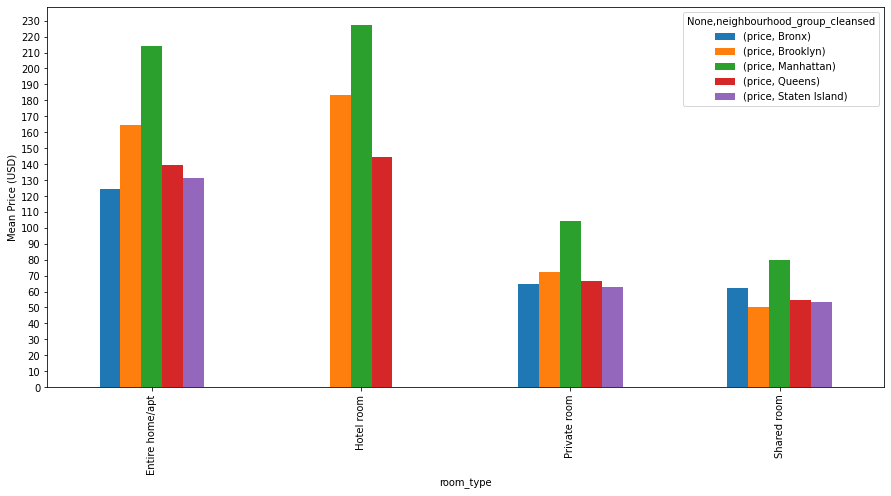

In [149]:
grouped_data_price
fig, price_plot = plt.subplots(figsize=(15,7))

major_ticks = np.arange(0, 500, 10)
price_plot.set_yticks(major_ticks)
plt.ylabel("Mean Price (USD)")

grouped_data_price.unstack().plot.bar(ax = price_plot)

### Conclusion for Question 1
- In general, the price trend for different types of neighbourhoods: **Manhattan > Brooklyn > Queens > Bronx > Staten Island**

- In general, the price trend for different types of properties: **Hotel Room > Entire Home/Apartment > Private Room > Shared Room**

- It is cheaper to stay in an Entire Home/Apartment property than a Hotel Room in New York

- In Bronx, Private Room and Shared Room cost just about the same

## Question 2
### What factors contribute towards a host rating? What aspects could possibly help a host get a better rating?

In [150]:
df = df_orig

# Question specific wanted columns
wanted_cols = [
    'host_since', 'host_response_time', 'host_response_rate',
    'host_acceptance_rate', 'host_total_listings_count', 'host_verifications',
    'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'availability_30', 'availability_60',
    'availability_90', 'availability_365', 'host_is_superhost'
]
df_subset = df[wanted_cols]
df_subset.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_total_listings_count,host_verifications,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,availability_30,availability_60,availability_90,availability_365,host_is_superhost
0,12.0,4,22,50,0.0,1,80.0,NaN,NaN,NaN,NaN,NaN,NaN,30,60,90,365,0
1,12.0,8,93,36,6.0,9,94.0,9.0,9.0,10.0,10.0,10.0,9.0,30,60,90,365,0
2,12.0,10,89,95,1.0,6,89.0,9.0,9.0,10.0,9.0,9.0,8.0,30,55,71,233,0
3,11.0,1,0,75,1.0,5,90.0,10.0,9.0,10.0,10.0,10.0,9.0,0,0,0,0,0
4,11.0,1,0,67,1.0,8,90.0,8.0,8.0,10.0,10.0,9.0,9.0,30,60,90,365,0


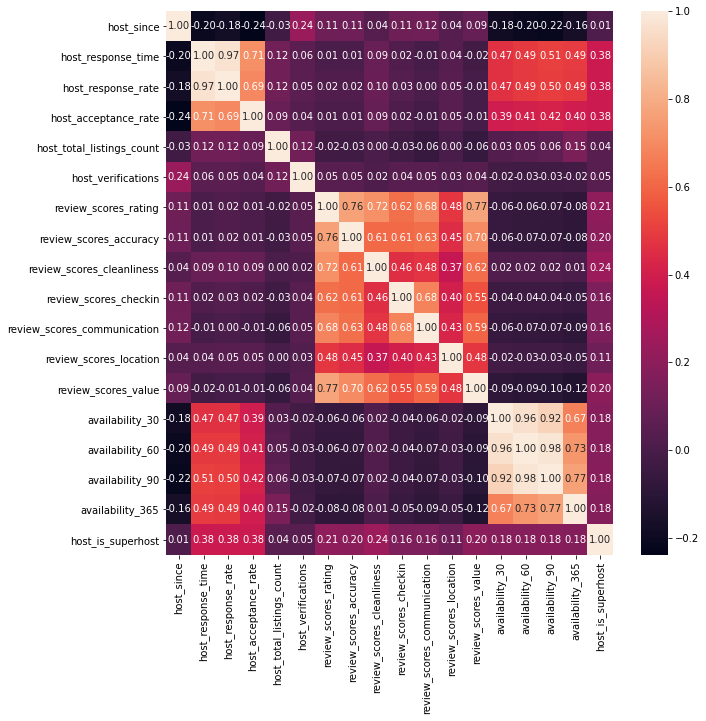

In [151]:
# Correlation heatmap to understand data better
fig, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(df_subset.corr(), annot=True, fmt=".2f", ax=ax)
plt.show()

### Conclusion for Question 2
 1. All review scores are highly correlated with each other as it was expected
 2. Reviews and Availability show negative correlation which was expected as properties with higher review rating are expected to be heavily booked
 3. It was expected that host_response_time and host_response_rate would have a positive corelation with the review_score_communication but was found otherwise
 4. It was also expected that host_reponse_rate and host_repsonse_time will have a negative correlation with availability but turned out to be otherwise
 5. It was unexpected to see that number of years as host has low negative correlation with response time, response rate and acceptance rate
 

# Data Modeling
Used Liner Regression model for training
## Question 3
### How can a host be entitled as a Superhost? How can they set a competitive rental price for their listing? How can a host maintain good review rating for their listing?

In [152]:
df = df_orig

# Question specific feature columns
wanted_X_cols = [
    'host_response_time', 'host_response_rate', 'host_acceptance_rate',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'review_scores_accuracy', 'availability_30',
    'availability_60', 'availability_90', 'availability_365',
    'cancellation_policy', 'neighbourhood_group_cleansed', 'room_type',
    'bathrooms', 'bedrooms', 'beds', 'host_verifications',
    'host_listings_count', 'host_total_listings_count',
    'host_identity_verified', 'host_has_profile_pic', 'accommodates',
    'bed_type', 'guests_included', 'minimum_nights', 'maximum_nights',
    'minimum_minimum_nights', 'maximum_minimum_nights',
    'minimum_maximum_nights', 'maximum_maximum_nights',
    'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
    'number_of_reviews', 'number_of_reviews_ltm', 'instant_bookable',
    'is_business_travel_ready', 'require_guest_profile_picture',
    'require_guest_phone_verification', 'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
    'square_feet'
]

R-Squared Score for our Model is:  0.29629460641955363





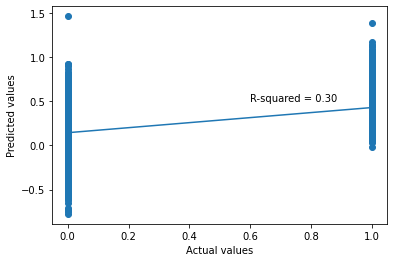

In [153]:
# Prediction Column
wanted_Y_col_is_superhost = ['host_is_superhost']

# Split into Train and Test Data
X_train, X_test, Y_train, Y_test = drop_and_split(
    df, wanted_X_cols, wanted_Y_col_is_superhost)

# Fit and Predict Data
rsquared_score, y_test_actuals, y_test_predictions = fit_and_predict(X_train, X_test, Y_train, Y_test)
print("R-Squared Score for our Model is: ", rsquared_score)
print("\n\n")

# Plot Scatter Plot
plot_scatter(y_test_actuals, y_test_predictions, rsquared_score)

R-Squared Score for our Model is:  0.39622173722433696





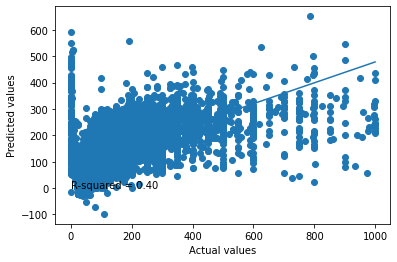

In [154]:
# Prediction Column
wanted_Y_col_rental_price = ['price']

# Split into Train and Test Data
X_train, X_test, Y_train, Y_test = drop_and_split(
    df, wanted_X_cols, wanted_Y_col_rental_price)

# Fit and Predict Data
rsquared_score, y_test_actuals, y_test_predictions  = fit_and_predict(X_train, X_test, Y_train, Y_test)
print("R-Squared Score for our Model is: ", rsquared_score)
print("\n\n")

# Plot Scatter Plot
plot_scatter(y_test_actuals, y_test_predictions, rsquared_score)

R-Squared Score for our Model is:  0.7541539777824317





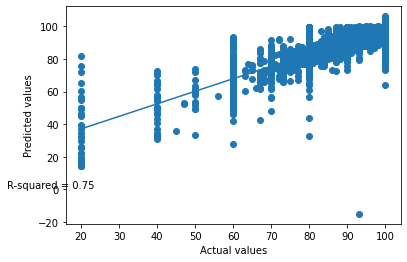

In [155]:
# Prediction Column
wanted_Y_col_review_score = ['review_scores_rating']

# Split into Train and Test Data
X_train, X_test, Y_train, Y_test = drop_and_split(
    df, wanted_X_cols, wanted_Y_col_review_score)

# Fit and Predict Data
rsquared_score, y_test_actuals, y_test_predictions  = fit_and_predict(X_train, X_test, Y_train, Y_test)
print("R-Squared Score for our Model is: ", rsquared_score)
print("\n\n")

# Plot Scatter Plot
plot_scatter(y_test_actuals, y_test_predictions, rsquared_score)

### Conclusion for Question 3
- Linear Regression can be a good enough model for predicting review_score_rating based on the feature set
- The models comply with the findings from heatmap correlation
- Exploration of other models is required in future to better predict host_is_superhost and price features

# Evaluating the Results
Results and discussions are published at https://medium.com/@sakshigoplani9/torque-your-airbnb-spin-in-new-york-557c5902f5de